In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split

## Load Train and Test Datasets

In [2]:
# Load training data
df_train = pd.read_csv('../../0_Datasets/IoMT_AI_IDS/train.csv')

In [3]:
# Load testing data
df_test = pd.read_csv('../../0_Datasets/IoMT_AI_IDS/test.csv')

In [4]:
X_train = df_train.drop(['is_attack'], axis=1)  # Features
y_train = df_train['is_attack']  # Target variable

In [5]:
X_test = df_test.drop(['is_attack'], axis=1)  # Features
y_test = df_test['is_attack']  # Target variable

## Load Model

In [6]:
# Save the trained model to a specific folder
model_folder = "../../2_Modeling_Phase/Saved_Models/"
model_filename = "IoMT_AI_IDS_XGBoost.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

---

# Feature Importance

In [7]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

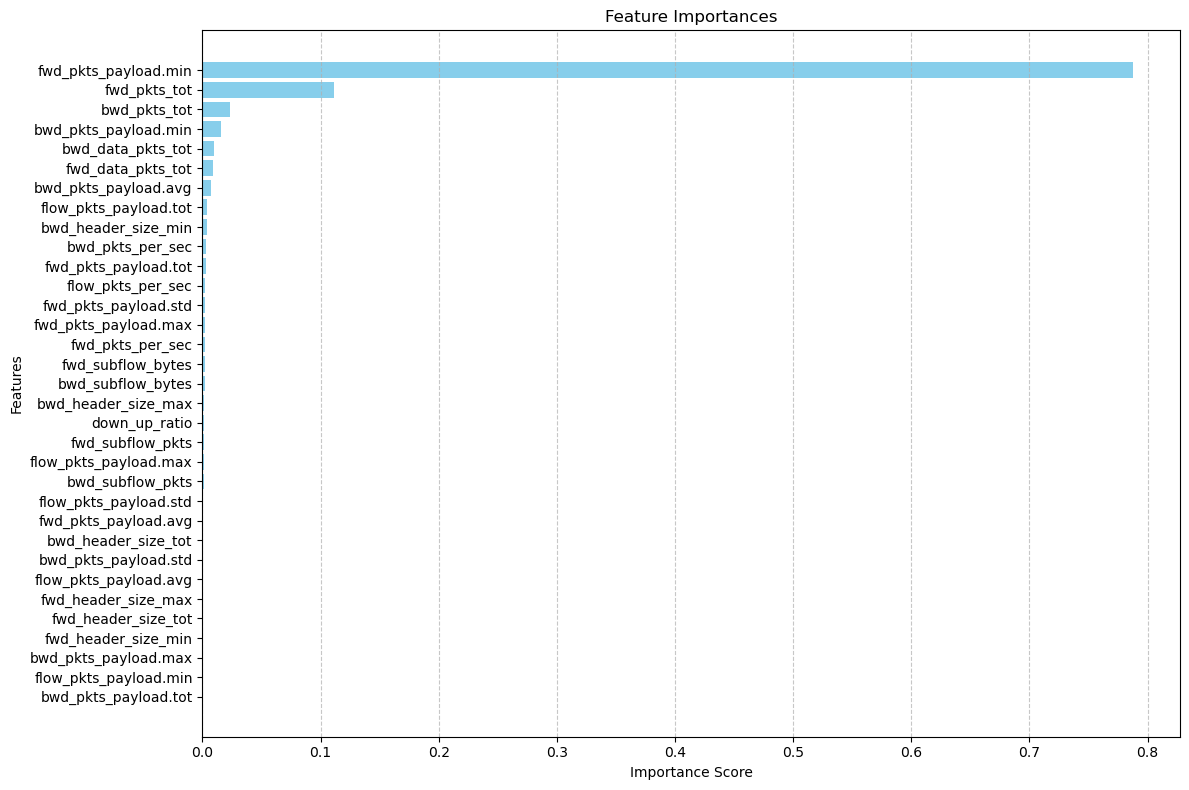

In [8]:
# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar plot
ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

# Set y-axis labels
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

# Set title and labels
ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

# Invert y-axis for better readability
ax.invert_yaxis()

# Add grid for better visualization
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: total: 15.6 ms
Wall time: 5.41 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,fwd_pkts_payload.min,14,0.788029,1.000000
1,fwd_pkts_tot,0,0.111042,0.969697
2,bwd_pkts_tot,1,0.023072,0.939394
3,bwd_pkts_payload.min,19,0.015701,0.909091
4,bwd_data_pkts_tot,3,0.009730,0.878788
5,fwd_data_pkts_tot,2,0.008595,0.848485
6,bwd_pkts_payload.avg,22,0.007519,0.818182
7,flow_pkts_payload.tot,26,0.003597,0.787879
8,bwd_header_size_min,12,0.003550,0.757576
9,bwd_pkts_per_sec,5,0.003375,0.727273


## InterpretML

In [10]:
#pip install interpret

In [11]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test, feature_names=feature_names)

explanation = msa.explain_global()

# Extracting the Morris sensitivity results as a DataFrame
sensitivity_df = pd.DataFrame(explanation.data()["scores"], index=feature_names)
sorted_sensitivity_df = sensitivity_df.sort_values(by=sensitivity_df.columns[0], ascending=False)
print(sorted_sensitivity_df)

show(explanation, max_features=len(feature_names))

C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\SALib\util\__init__.py:302: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_group_names = pd.unique(groups)
C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\SALib\util\__init__.py:302: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_group_names = pd.unique(groups)


CPU times: total: 3.58 s
Wall time: 376 ms
                              0
flow_pkts_payload.tot  0.212061
fwd_pkts_payload.min   0.149331
fwd_pkts_tot           0.120517
bwd_pkts_per_sec       0.075868
flow_pkts_per_sec      0.069929
fwd_pkts_per_sec       0.050416
bwd_pkts_payload.std   0.043715
fwd_pkts_payload.tot   0.032811
fwd_pkts_payload.max   0.030557
bwd_pkts_tot           0.030202
flow_pkts_payload.max  0.030029
fwd_header_size_tot    0.025993
fwd_pkts_payload.std   0.024789
fwd_subflow_bytes      0.022640
fwd_data_pkts_tot      0.021855
down_up_ratio          0.017855
fwd_subflow_pkts       0.016974
bwd_header_size_min    0.015553
flow_pkts_payload.std  0.009841
flow_pkts_payload.avg  0.008965
fwd_pkts_payload.avg   0.008638
bwd_pkts_payload.avg   0.007919
bwd_subflow_pkts       0.004289
bwd_header_size_tot    0.002361
fwd_header_size_max    0.001973
bwd_data_pkts_tot      0.001219
bwd_header_size_max    0.000671
bwd_subflow_bytes      0.000343
bwd_pkts_payload.min   0.0003

<!-- http://127.0.0.1:7001/2428954671056/ -->

## Shap

## LOFO

In [12]:
#pip install lofo-importance

In [13]:
from lofo import LOFOImportance, Dataset
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="is_attack", feature_names=feature_names)

importance

ModuleNotFoundError: No module named 'lofo'